<a href="https://colab.research.google.com/github/krishnagevariya05/Rice_Leaf_Diseases/blob/main/Rice_leaf_diseases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tf-nightly-gpu-2.0-preview
!pip install tf-hub-nightly
!pip install tensorflow==2.0.0-alpha0

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.5'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is NOT AVAILABLE


Load The Data

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/rice-leaf.zip', 'r')
zip_ref.extractall('/content/drive/MyDrive')
zip_ref.close()

In [ ]:
data_dir = "/content/drive/MyDrive/rice"
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /content/drive/MyDrive/rice/train : 0files
total images for validation : /content/drive/MyDrive/rice/validation : 0files


In [ ]:

import json

with open('/content/classes.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())

print (classes)


['Bacterial_leaf_blight', 'blast', 'brownspot']


In [ ]:
print('Number of classes:',len(classes))

Number of classes: 3


Select the Hub/TF2 module to use

In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}


Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


Data Preprocessing

In [ ]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 84 images belonging to 3 classes.
Found 157 images belonging to 3 classes.


Build the model

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])


In [ ]:
import tensorflow_hub as hub

In [ ]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True

else:
  feature_extractor.trainable = False


In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))

model.summary()


Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 22,853,411
Trainable params: 1,050,627
Non-trainable params: 21,802,784
_______________

In [ ]:

#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE),
   loss='categorical_crossentropy',
   metrics=['accuracy'])


In [ ]:
EPOCHS=30 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)


<ipython-input-25-3973d0645cb6>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
2/2 [==============================] - 47s 28s/step - loss: 0.1428 - accuracy: 0.9247 - val_loss: 1.2933 - val_accuracy: 0.7031
Epoch 2/30
2/2 [==============================] - 57s 38s/step - loss: 0.1253 - accuracy: 0.9531 - val_loss: 1.2037 - val_accuracy: 0.7031
Epoch 3/30
2/2 [==============================] - 47s 26s/step - loss: 0.0757 - accuracy: 0.9785 - val_loss: 1.1280 - val_accuracy: 0.7031
Epoch 4/30
2/2 [==============================] - 48s 30s/step - loss: 0.1368 - accuracy: 0.9570 - val_loss: 1.2296 - val_accuracy: 0.7031
Epoch 5/30
2/2 [==============================] - 44s 36s/step - loss: 0.0995 - accuracy: 0.9462 - val_loss: 1.4357 - val_accuracy: 0.7188
Epoch 6/30
2/2 [==============================] - 56s 37s/step - loss: 0.1147 - accuracy: 0.9453 - val_loss: 1.6228 - val_accuracy: 0.7500
Epoch 7/30
2/2 [==============================] - 48s 40s/step - loss: 0.0831 - accuracy: 0.9677 - val_loss: 1.4792 - val_accuracy: 0.7500
Epoch 8/30
2/2 [===========

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Display accuracy
print("Training Accuracy: {:.2f}%".format(acc[-1] * 100))
print("Validation Accuracy: {:.2f}%".format(val_acc[-1] * 100))

# Display loss
print("Training Loss: {:.4f}".format(loss[-1]))
print("Validation Loss: {:.4f}".format(val_loss[-1]))

Training Accuracy: 99.22%
Validation Accuracy: 71.88%
Training Loss: 0.0420
Validation Loss: 1.5149


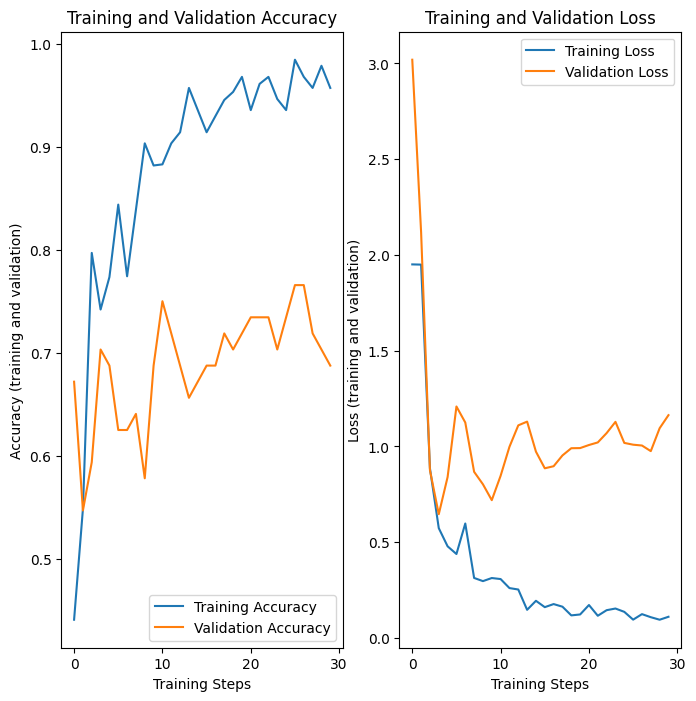

In [ ]:
import matplotlib.pylab as plt
import numpy as np


epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()



In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255

    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)

    return {classes[class_idx]: probabilities[class_idx]}


SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_041.jpg
1/1 [==============================] - 1s 1s/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.572780


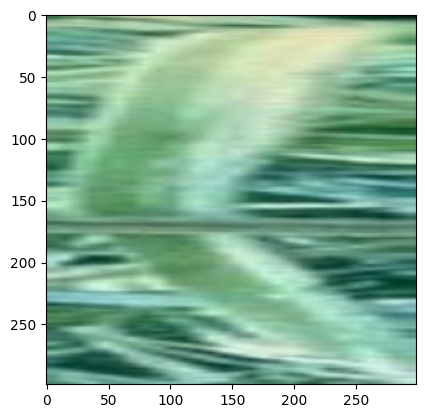

<Figure size 640x480 with 0 Axes>

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_019.jpg
1/1 [==============================] - 0s 249ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.906972


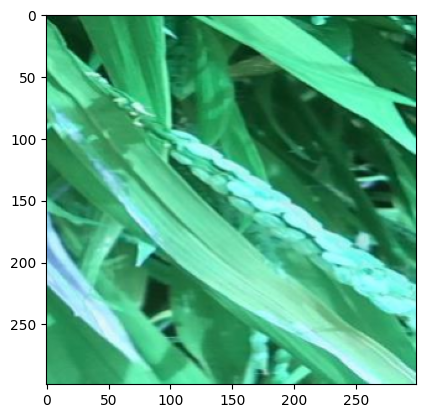

SOURCE: class: bacterial_leaf_blight, file: bacterial_leaf_blight/blight_rotated_009.JPG
1/1 [==============================] - 0s 230ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.727373


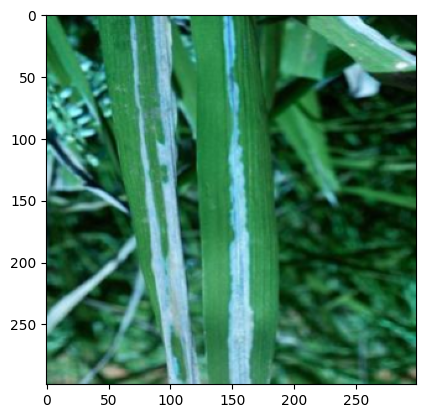

<Figure size 640x480 with 0 Axes>

SOURCE: class: brownspot, file: brownspot/brownspot_rotated_005.jpg
1/1 [==============================] - 0s 350ms/step
PREDICTED: class: Bacterial_leaf_blight, confidence: 0.890784


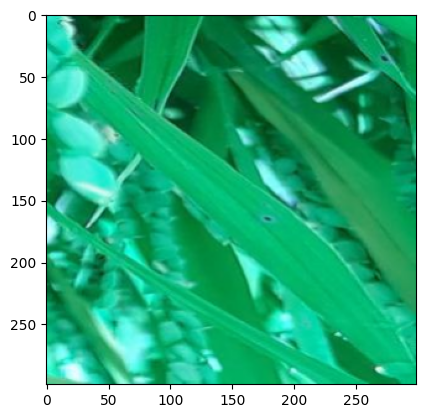

<Figure size 640x480 with 0 Axes>

SOURCE: class: blast, file: blast/blast_rotated_014.png
1/1 [==============================] - 0s 244ms/step
PREDICTED: class: blast, confidence: 0.969575


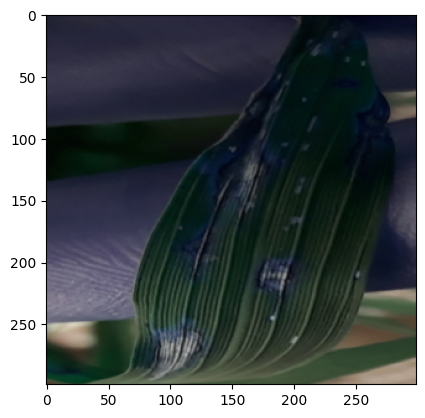

<Figure size 640x480 with 0 Axes>

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))

    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)
    plt.show()
